<a href="https://colab.research.google.com/github/Urvi-M/BE559/blob/main/Homework4_part3_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4.3 (46 points)

**Learning objectives:**

In this assignment, we will continue to explore dimensionality reduction. We will:

* make connections between dimensionality reduction via principal components regression and other regression methods such as partial least squares and ridge regression.

* See how probabilistic approaches such as PPCA and factor analysis can be used for model selection.

##<font color='red'> WARNING: THIS HOMEWORK SEEMS LONG, BUT MANY PARTS THE CODE IS INCLUDED. SO ITS REALLY MORE LIKE A GUIDED TOUR, FOR MANY OF THE PARTS. For example, Parts equaling almost half of the work, 20 points, don't require you do to anything but read. </font>

##<font color='green'> PARTS COLORED IN GREEN ARE ESSENTIALLY DONE ALREADY, ALL YOU NEED TO DO IS FOLLOW THROUGH THEM. </font>


---
Load our standard libraries, and set our standard font size:

*   `numpy` (as `np`)
*   `matplotlib.pyplot` (as `plt`)
*   `pandas` as (`pd`)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 12})

## <font color='green'> Part 1 (4 points) </font>

We are going to work through a toy dataset to see how partial least squares can improve regression results when compared to principal components regression. This toy dataset was originally considered [here](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py). All code cells will be shown here, but pay attention to what's going on, so you can perform a similar analysis below!

First, let's generate a synthetic 2 dimensional dataset. This will help us understand what principal components regression and partial least squares are doing.

In [2]:
rng = np.random.RandomState(0) #set the random seed
n_samples = 500 #how many samples of data to use
cov = [[3, 3], [3, 4]] #construct the covariance matrix, which will determine how feature 1 and 2 covary
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples) #create the 2 dimensional data

Do PCA on this fake data.

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)

And then plot it. It should be clear that PC1 is larger then PC2.

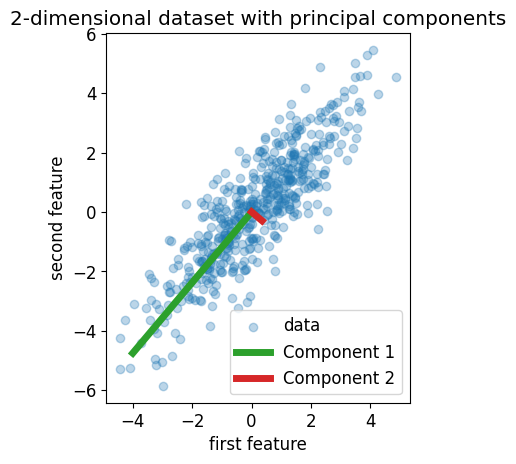

In [4]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="data")

for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]],
        label=f"Component {i+1}",
        linewidth=5, color=f"C{i + 2}")

plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature")

plt.legend();

Now, let's create a variable that we might want to predict, `y` as a function of **PC2**. This means that the smaller PC2 is the most predictive dimension of `y`.

In [5]:
y = X.dot(pca.components_[1]) + rng.normal(size=n_samples) / 2

Plotting a scatter plot of this should make it the most clear: PC1 is not very correlated with `y` and PC2 is very correlated with it!

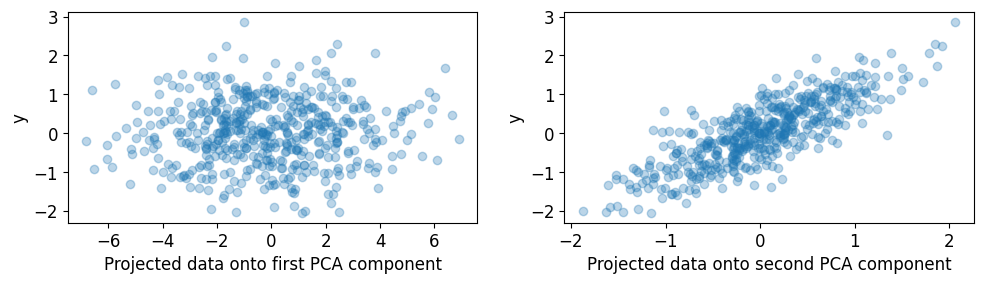

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(X.dot(pca.components_[0]), y, alpha=0.3)
axes[0].set(xlabel="Projected data onto first PCA component", ylabel="y")
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=0.3)
axes[1].set(xlabel="Projected data onto second PCA component", ylabel="y")
plt.tight_layout();

Now let's use `sklearn` to fit a [principal components regression](https://en.wikipedia.org/wiki/Principal_component_regression) (PCR) model and a [partial least squares](https://en.wikipedia.org/wiki/Partial_least_squares_regression) (PLS) model to these data.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

[`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) is a handy method for 'stacking' together multiple processing steps into a single function, as we will need to do for PCR. Recall that PCR is two steps:

- Do PCA
- Do regression using the PCs.

First divide the data into a training and testing set using skelearn's method [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
rng = np.random.RandomState(2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)


Let's use `make_pipline` to construct our PCR model, and then fit it. Recall from lecture that PCA simply seeks to find directions within the covariance of our `X` data that lead to the maximum amount of variance. In other words it seeks to maximize an objection function of the form: $$ J(w) = \textrm{Var}(Xw).$$ So it will find PC1!

In [10]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=1)),
                ('linearregression', LinearRegression())])

Because we used `make_pipeline` to fit our PCR model, the PCA 'part' of it is 'tucked within' our `pcr` object. To 'pull out' the PCA only part, we can use the attribute `named_steps`.

In [11]:
pca = pcr.named_steps["pca"]

Now, let's fit the PLS model with 1 component. Recall from lecture that PLS is doing something different than PCA! It seeks to find large variance directions in `X` that ALSO correlate with `y`. In other words it seeks to maximize an objection function of the form: $$ J(w) = \textrm{Corr}^2(y, Xw) \textrm{Var}(Xw).$$ It will balance the $w$ that it finds to be sure that $Xw$ is correlated with $y$ (i.e. so it is predictive of $y$), but also that the variance of $Xw$ is large (much like a PC)!


[`PLSRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html) is an easy to use sklearn method for fitting PLS models.

In [12]:
from sklearn.cross_decomposition import PLSRegression

In [13]:
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train);

Both `pca` (the part we pulled out of `pcr`) and `pls` have `transform()` methods associated with them, for projecting the original data into the lower-dimensional space. `pcr` (the object we created that does both PCA and linear regression) has a `predict` method associated with it (its just the `predict` method from the `linearregression` part of our pipeline). `pls` also has a `predict` method associated with it. Both methods compute the approximation to `y` based on their respective projection of the data.

* Let's plot a scatterplot for each method. First we will scatter the data projected down to the lower dimensional space against `y`. Second we will scatter the data projected down to the lower dimensional space against each model's prediction of `y`.

From the PCR/PCA plot, we can see that PCR finds PC1, which isn't very correlated with `y`, which we already knew. And as a result, the `pcr` prediction of `y` is pretty much zero everywhere.

From the PLS plot, we can see that PLS finds an axis that is correleated with `y`, and as a result, the `pls` prediction of `y` is pretty good!

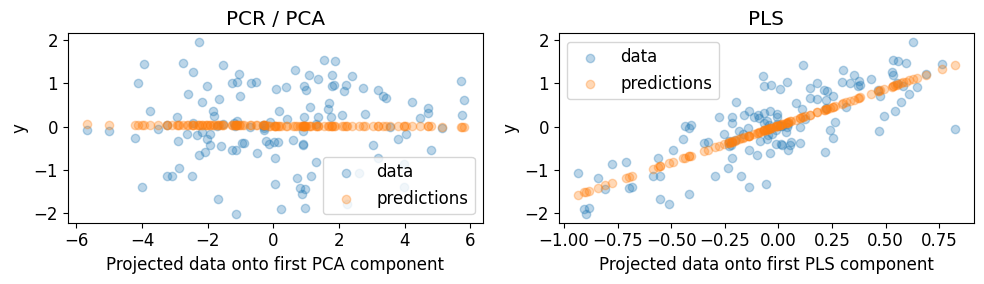

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="data")
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA")
axes[0].legend()

axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="data")
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout();

Finally, let's use the `score` method ([PLS](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression.score) and [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) to predict the model accuracy. Score is the coefficient of determination $R^2$ (i.e. 1 - normalized error).

In [15]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared -0.002
PLS r-squared 0.619


---
## Part 2 (4 points)

Now that we've seen PLS in action against PCR, let's do the same analysis on our decathalon dataset.

First, let's more or less redo some steps from HW4.1.

*   Load the Olympic Decathalon dataset at the following URL: https://raw.githubusercontent.com/BU-BME-DataSci-ML/Spring-2023/main/Homework4/decathalon.csv. To do this, use the pandas function `pd.read_csv` to create a a `pandas` DataFrame, which we will call `df`.

* Create a reduced dataframe, called `X` that removes some of the information from our dataset that we don't need, such as the athletes name, their rank, points, and which sporting event the data corresponds to. These correspond to the first, and last three columns of out dataframe. A dataframe has some handy functionality that we will exploit. Each dataframe has an attribute `.columns` which lists the column names of the dataframe. This can be indexed into (i.e., [1:2], etc.) to pull out only the column names we are intersted in. THEN, this list of column names can be used to index into our dataframe itself, to only take the columns we are interested in. Use `X = df[df.columns[1:-3]]` to generate a reduced dataframe `X` of the data we want.

**STEPS WITH CODE INCLUDED**

* Use `y = df[df.columns[-2:-1]]` to create a reduced dataframe of the points each athlete was awarded. We want to see if we can make a good prediction of this based on a projection of the data in `X` onto a reduced space of features.

* Use `features = X.columns` to make a list of the names of the features, for easy plotting.

* Scale the data in `X` using `sklearn`'s `StandardScaler()`.

* Divide the data into train and test sets using `train_test_split`. Set the optional arguments to `random_state=np.random.RandomState(2)` and `test_size=0.5`)

**STEPS WITH NO CODE INCLUDED**

* Use `make_pipeline` to create a pca analysis that includes a `standard_scaler()` step and a `pca` step.

* Fit your `pca` pipeline to your training data.

* Plot a scatter plot of the PC1 projection of your testing data against your `y` testing data. As we saw in HW4.1, PC1 is pretty correlated with `y`! But is it the *most* correlated linear projection of `X`?

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/BU-BME-DataSci-ML/Spring-2023/main/Homework4/decathalon.csv')
X = df[df.columns[1:-3]]
y = df[df.columns[-2:-1]]
D = np.shape(X)[1]
features = X.columns;

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=np.random.RandomState(2), test_size=0.5)
y_train = y_train.to_numpy()

Text(0.5, 1.0, 'PCA')

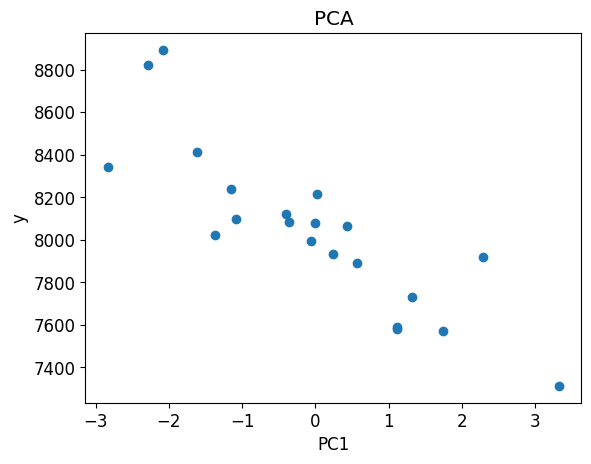

In [19]:
pc= make_pipeline(StandardScaler(), PCA(n_components=len(features)))
pc.fit(X_train, y_train)
plt.plot(figsize=(8, 3))
a=pc.transform(X_test)
plt.scatter(a[:,0], y_test)
plt.xlabel('PC1')
plt.ylabel('y')
plt.title('PCA')

## Part 3 (4 points)

Perform principal components regression and partial least squares on the decathalon dataset, much like we did above for the toy dataset.

* Perform both analysis to find a 1-dimensional projection of the data that best predicts $y$.

* To perform PCR, create a `pipeline` with the following components: a starndard scaler, PCA and linear regression. Fit the PCR model to the training data. Used `named_steps`, as we did above to pull out the components of the pipeline that we need to do plotting, etc.

* Plot a scatterplot for each method, as we did above. First we will scatter the data projected down to the lower dimensional space against `y`. Second we will scatter the data projected down to the lower dimensional space against each model's prediction of `y`.

* Compute the $R^2$ value for both models on test data, using the `score()` method, as we did above.

In [20]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

PLSRegression(n_components=1)

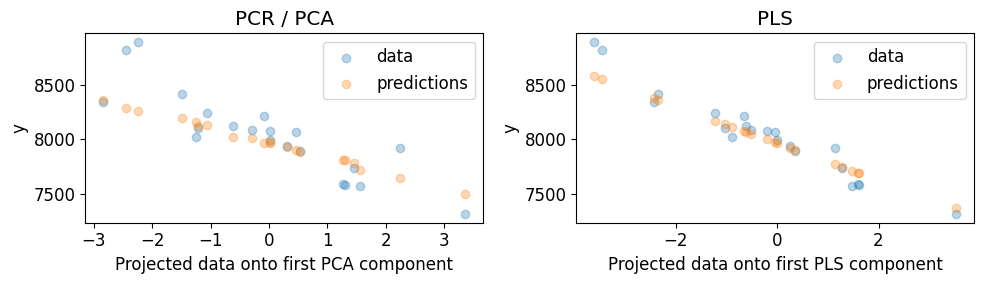

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="data")
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA")
axes[0].legend()

axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="data")
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout();

In [22]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.620
PLS r-squared 0.900


## Part 4 (2 points)

Both PCR and PLS have found a 1-dimensional projection of the features in our data. In HW 4.1 we examined the loadings of this projection to understand what 'new feature' PC1 was representing. Let's do the same here for both methods.

* Plot the entries of PCR and PLS for the first dimension, setting the x axis to the feature names. (For getting the names of the features on the x-axis, `plt.xticks` and `.columns` will be helpful).

* For PLS, the attribute `.coef_` provides the projection vector.

* For PCR, our pipeline contains **TWO** components that collectively determine the projection vector: the `components_` attributue of the `pca` part determines the projection down to the lower dimension space and the `.coef_` attribute of the `linearregression` part determines how the data projected onto PC1 are scaled to predict `y`. In other words, the total projection vector of PCR is `linearregression.coef_` times `pca.components_`. Use `named_steps` to pull these out to plot the projection vector of PCR.

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


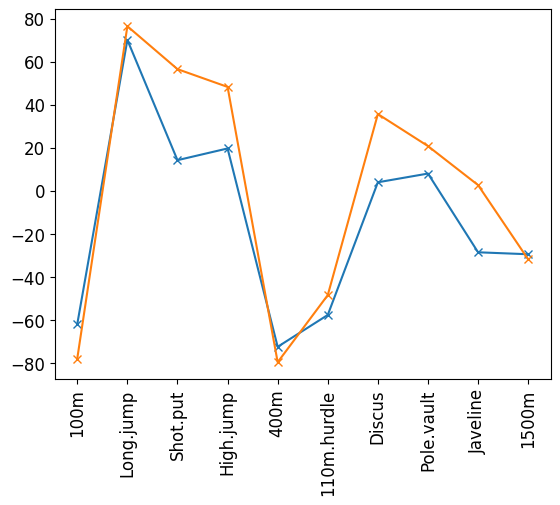

In [23]:
linear_regression = pcr.named_steps["linearregression"]
plt.plot(features,(pca.components_.flatten() * linear_regression.coef_).reshape(-1,1),'x-')
plt.plot(features,pls.coef_,'x-')
plt.xticks(rotation=90)
plt.show()

<font color='red'>**SHORT ANSWER (4 points):** Name 1 feature that is similar between PCR and PLS and 1 feature that is different. What does this mean about what PLS is doing above and beyond PCA?</font>  

a Similar feature would be 1500m and different feature would be shot shoutput.
While PCA focuses solely on maximizing variance in the input features to find orthogonal components, PLS takes into account both the variance in the input features and the relationship between the input features and the target variable (in this case, the points obtained in the decathlon). This allows PLS to potentially provide a more predictive model by capturing not only the variance but also the covariance between features and the target variable, leading to potentially better performance, especially in situations where the correlation between the input features and the target variable is not adequately captured by PCA.

## <font color='green'> Part 5 (4 points) </font>

So far, we have examined the connection between PLS and PCA. Ridge regression (from module 2!) can also be connected to PCA/PCR in a way that is illuminating. We will examine that connection here.

PCR essentially 'zeros out' all discarded PCs and predicts `y` from the kept PCs. Ridge regression can be cast as a weighted sum of all the PCs to predict `y`, with smaller PCs being used less (but not discarded entirely). To see this we need to do some linear algebra, and recall the singular value decomposition of a matrix.

First, let's be careful with our dimensions. $X$, our data matrix, is a $N \times D$ matrix, where $N$ is the number of samples, and $D$ is the number of features.

Recall from the definition of the [singular value decompostion](https://en.wikipedia.org/wiki/Singular_value_decomposition) that any matrix can be written as

$$ X = U S V^T$$

where $U$ is a $N \times N$ [unitary, i.e. orthogonal in the case of a real values matrix](https://en.wikipedia.org/wiki/Orthogonal_matrix) matrix, $S$ is a $N \times D$ matrix with the singular values along its diagonal, and $V^T$ is a $D \times D$ unitary matrix.

If I compute the $D \times D$ covariance matrix of our data, $X^TX$, and subsititue our defintion of $X$ above, we can see that the singular value decomposition is related to the eigenvalue decomposition in the following way:

$$ X^T X = V S U^TU S V^T = VS^2V^T.$$

(Note that $U^TU = I$). Here we can see that $S^2$ are the eigenvalues and $V$ are the eigenvectors of the covariance matrix.

To make this more explicit, if I start with the singular value decomposition of $X$, $ X = U S V^T$, and multiply it on the right by $V$, I get $XV = USV^TV = US$. Recall that $V$ is $D \times D$, $X$ is $N \times D$, $U$ is $N \times N$ and $S$ is $N \times D$ and diagonal. $XV = US$ means that if I project my data onto the eigenvectors $V$ (ie compute the principal components) this should be equal to the rows of $U$ scaled by the corresponding singular value in $S$.

We are going to confirm this.

**STEPS WITH CODE INCLUDED**

* First, we need to remove the mean from our data. (This just makes subsequent analysis easier.)

**STEPS WITH NO CODE INCLUDED**

* Use `np.linalg.eig` to compute the eigenvalues and eigenvectors of $X^TX$ (of your demeaned data).

* Use `np.linalg.svd` to compute the singular values and the left singular vectors ($U$) of $X$ (demeaned).

* Project $X$ onto the first eigenvector to compute PC1. Multiply the first column of $U$ by the first singular value of $X$.

* Plot both to show they are the same thing (one may be the negative of the other, but they should be identical otherwise).

Your plot should look like this:

In [24]:
X_train_dm = X_train - np.mean(X_train, axis=0)
X_test_dm = X_test - np.mean(X_test, axis=0)

In [25]:
eig, eigvec = np.linalg.eig(np.matmul(X_train_dm.T, X_train_dm))
PC1 = np.dot(X_train_dm, eigvec[:,0].T)

In [26]:
U, S, _ = np.linalg.svd(X_train_dm);
SVD1 = U[:,0] * S[0];

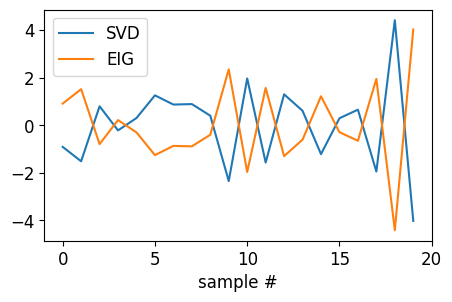

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(SVD1)
axes.plot(PC1);
axes.set(xlabel="sample #", xlim=[-1, 20], ylabel="")
axes.legend(['SVD', 'EIG'], fontsize=12);

## <font color='green'> Part 5 (6 points) </font>

In class, I derived an expression for the ridge solution that 'filters' $y$ based on the eigenvalues of the covariance matrix of $X$. I will illustrate that more fully here:

Recall that the ridge regression objective is $$J(w) = 1/2 ||y - X \beta||^2 + \lambda/2 ||\beta||^2,$$ where the ridge regression solution is

$$ \beta = (X^TX + \lambda I)^{-1}X^Ty$$

where $\beta$ is $D \times 1$. Recall that ridge regression is trying to find $y$ as linear combinations of $X$, $ y \approx X \beta$. If we plug $\beta$ in here, and plug in our singular value decompostion of $X$, $ X = U S V^T$, we get

$$ y \approx X \beta = X(X^TX + \lambda I)^{-1}X^Ty$$

$$ y \approx X \beta = U S V^T(VS^TU^TUSV^T + \lambda I)^{-1}V S^T U^Ty$$

(Note that $X^T = VSU^T$)

$$ y \approx X \beta = U S V^T(VS^TSV^T + \lambda I)^{-1}V S^T U^Ty$$

(Note that $U^TU = I$)

$$ y \approx X \beta = U S V^T(VS^TSV^T + \lambda VV^T)^{-1}V S^T U^TY$$

(Note that $I = VV^T = I$)

$$ y \approx X \beta = U S V^T(V(S^TS + \lambda)V^T)^{-1}V S^T U^Ty$$

(I pulled $V$ out to the left and $V^T$ out to the right).

(Next, note that $(ABC)^{-1} = C^{-1}B^{-1}A^{-1}$

$$ Y \approx X \beta = U S V^T((V^T)^{-1}(S^TS + \lambda)^{-1}V^{-1}V S^T U^Ty$$

(Note that $V^T(V^T)^{-1} = I$ and $V^{-1}V = I$)

$$ y \approx X \beta = U S (S^TS + \lambda)^{-1} S^T U^Ty$$

$$ y \approx X \beta = U S (S^TS + \lambda I)^{-1}S^T U^Ty$$

That was a long calculation! There is one more important point to mention: because $S$ is a $N \times D$ diagonal matrix, and generally $N > D$, all $D+1$ rows of $S$ will be all zeros! Which means that $U S$ will scale the first $D$ columns of $U$ by the respective element of $S$ and the $D+1$ columns of $U$ will essentially be zeroed out.

Because of the special stucture of $S$, its actually easier to think of the above expression in two parts:

- $U \frac{S^2}{S^2 + \lambda I}$ which will be equal to the first $D$ columns of $U$ each scaled by $\frac{s_d^2}{s_d^2 + \lambda I}$. Recall that $S^2$ will be the eigenvalues of $X^TX$, and so the scaling factor is the eigenvalues divided by the eigenvalues plus the regularization coefficient $\lambda$.

- $U^Ty$ which is the $N \times N$ matrix $U^T$ times the $N \times 1$ vector $y$. Recall from above that if each column of $U$ was proportional to an eigenvector of $X^TX$, then $U^T$ dotted with $y$ is the covariance of each of those columns with $y$, i.e. proportional to how much each eigenvector of the covariance of $X$ aligns with $y$! But again, because of the special structure of $S$, only the first $D$ columns (which correspond to the $D$ eigenvectors of $X^TX$ will be kept!)

So, in total this means the ridge solution $X \beta$ is a sum of $D$ $N$-dimensional vectors, where each vector is the product of $U_d \frac{s_d^2}{s_d^2 + \lambda} * (U_d \cdot y)$. $\frac{s_d^2}{s_d^2 + \lambda}$ and $(U_d \cdot y)$ are both scalars, and $U_d$ is proportional to the d-th principal component of $X$.

What do these two scalars do? Well if $U_d \cdot y$ is large, i.e. the d-th principal component of $X$ is correlated with $y$, that principal component will contribute strongly to the ridge solution (because this scalar will be big!). If $\frac{s_d^2}{s_d^2 + \lambda}$ is large, i.e. $\lambda$ is small (weak regularization) or a specific eigenvalue is very large, then again that principal component will contribute strongly to the ridge solution.

For example, we can compute $\frac{s_d^2}{s_d^2 + \lambda}$, for $\lambda = 10^{1}$ (i.e. a reasonably strong regularized ridge regression), using our singular values from above.

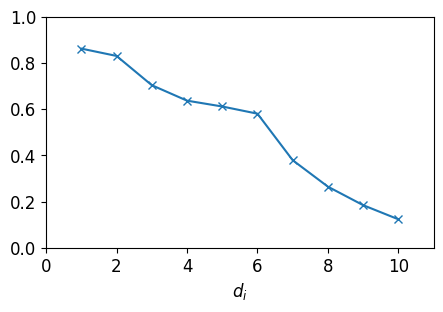

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(range(1, D+1), S**2 / (S**2 + 1e1), "x-");
axes.set(xlabel=r'$d_i$', xlim=[0, D+1], ylim=[0, 1]);

This essentially determines how 'much' of each PC will be 'available' for predicting $y$. (In PCR, for this plot all values below our PCA cutoff will be zero, all values above will be 1), such as the plot below.

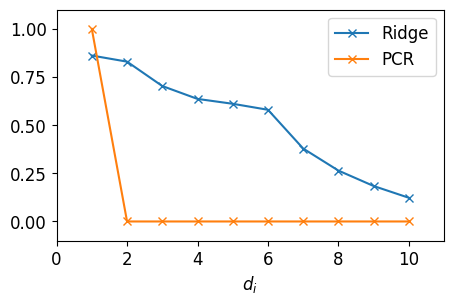

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(range(1, D+1), S**2 / (S**2 + 1e1), "x-");
axes.plot(range(1, D+1), np.hstack([np.ones(1), np.zeros(D-1)]), "x-");
axes.set(xlabel=r'$d_i$', xlim=[0, D+1], ylim=[-0.1, 1.1]);
axes.legend(['Ridge', 'PCR'], fontsize=12);

So, what this is all telling us is that PCR and ridge are actually quite similar, in that they scale different eigenvectors of the covariance of our $X$ data to predict $y$, although they scale them in quite different ways.

That was alot. Let's do some analysis to make this more concrete.

<font color='red'>**(6 points):** You get all 6 points if you type the following statement here: "I read the above derivation" :) </font>  

I read the above derivation

## Part 6 (2 points)

The term from above $\sum_d^D \frac{s_d^2}{s_d^2 + \lambda}$ is referred to as the number of "degrees of freedom" of the ridge solution. It is effectively a measure of how many "dimensions" you are using, in a weighted way. In order to accurately compare our ridge solution to PCR, in which we used 1 principal component to do regression, we need to set our ridge penalty $\lambda$ appropriately so that our degress of freedom equals 1.

* Scan over values of lambda from $10^{-3}$ to $10^{4}$ using `10.**np.linspace(-3,4,num=20)` and compute the degrees of freedom of the ridge regression solution based on the covariance of our training data. (Note that we computed the singular values above!)

* Plot the degrees of freedom vs. $log_{10}(\lambda)$. Your plot should look like this:

* Not a suprise -- the degrees of freedom should range from $D=10$ to 0.

In [30]:
lambda_values = 10.**np.linspace(-3, 4, num=20)

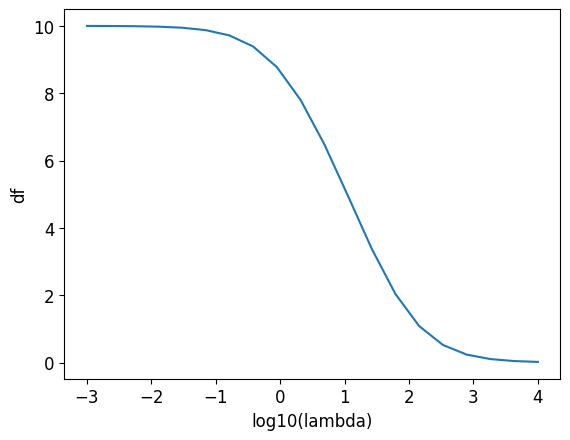

In [31]:
degrees_of_freedom = []
for lambda_val in lambda_values:
    dof = np.sum(S**2 / (S**2 + lambda_val))
    degrees_of_freedom.append(dof)

# Plot degrees of freedom vs. log10(lambda)
plt.plot(np.log10(lambda_values), degrees_of_freedom)
plt.xlabel('log10(lambda)')
plt.ylabel('df')

plt.show()

## <font color='green'> Part 7 (2 points) </font>

To find the value of $\lambda$ such that the degrees of freedom is 1, we need to find when $df = 1$, or when $df - 1 = 0$, i.e the root of that function. We will use the `scipy.optimize` function [`root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) to do this.

* Do `from scipy.optimize import root`

* Define a function `DF(lam, S, df)` that takes in a value of $\lambda$ (`lam`), the singular values of $X$ (`S`) and the target degrees of freeom (`df`) and computes $\sum_d^D \frac{s_d^2}{s_d^2 + lam} - df$.

* Do `res = root(DF, 1e-1, args=(S, 1.0))` to find the root of your function when `df=1.0`. `res.l` will be the value of $\lambda$ at the root.

* Print the value of $\lambda$. It should match what is below.

In [32]:
from scipy.optimize import root

In [33]:
def DF(lam, S, df):
  return sum(S**2 / (S**2 + lam)) - df

In [34]:
res = root(DF, 1e-1, args=(S, 1.))
l = res.x

In [35]:
print(f"Regularization coeffcient {res.x[0]:.3f}")

Regularization coeffcient 158.641


## Part 8 (2 points)

We are ready to fit our ridge regression with one degree of freedom!

* Use the `sklearn` class [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Remeber we used this in module 2! Do `from sklearn.linear_model import Ridge`.

* Demean your `y` training and testing data, like we did above for `X`.

* Do `ridge = Ridge(alpha=lam)` to create a ridge object with a regularization term `lam`.

* Use the [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.fit) method of ridge to fit the model to your training data.

* Use the [`score`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.score) method to show the $R^2$ on the testing data.

In [36]:
from sklearn.linear_model import Ridge

In [37]:
y_train_dm = np.array(y_train - np.mean(y_train, axis=0))
y_test_demeaned = y_test - np.mean(y_train, axis=0)
ridge =Ridge(alpha= l)
ridge.fit(X_train, y_train_dm)

Ridge(alpha=array([158.64115288]))

In [38]:
r2_test = ridge.score(X_test, y_test_demeaned)

print(f'Ridge r-squared: {r2_test:.3f}')

Ridge r-squared: 0.329


## <font color='green'> Part 9 (4 points)</font>

Recall from part 5 that we wanted to compare the weighted singular values of our $X$ matrix to the ridge solution. But, we didn't know how to weight them, because we didn't know which $\lambda$ we were going to use for regularization. Now we do!

* Compute $U_d \frac{s_d^2}{s_d^2 + \lambda}$ for the first $D=10$ singular vectors of $X$, i.e. the first $D$ columsn of $U$. Use the $\lambda$ we computed above to get the degress of freedom of our ridge solution to equal 1. You should have $D=10$ $N$-dimensional vectors.

* Compute the dot product between the demeaned values of your training data $y$ and the first $D$ singular vectors of $X$, i.e. the first $D$ columns of $U$. You should have $D$ scalar values.

* Plot the absolute value of $U_d \cdot y$ (for demeaned y training data). It should look like the plot below. This tells you how much each PC of $X$ covaries with $y$ in the training data. It's reasonable that there's a large value of PC1 (we'd hope so!) but the fact that this DOES NOT drop off monotonically suggests that large PCs aren't always the most predictive of $y$!

* Compute the product of $U_d \frac{s_d^2}{s_d^2 + \lambda} * U_d \cdot y$ for all $D$. This should give you $D$, $N$-dimensional vectors.

* Sum these vectors across $D$. (You should now have one $N$ dimensional vector.) Show this is equal to the prediction provided from the ridge solution of the training data, i.e. what your ridge solution returns when you use the [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.predict) method of your ridge solution on you demeaned X training data.

* Plot $U_d \frac{s_d^2}{s_d^2 + \lambda} * U_d \cdot y$ for the first PC (i.e. the first column of $U$) and the last PC. You should plot 2, $N$-dimensional vectors.

* Plot the sum of $U_d \frac{s_d^2}{s_d^2 + \lambda} * U_d \cdot y$ across all $D=10$ PCs and the ridge solution. They should look the same. You should plot 2, $N$-dimensional vectors.

Your plots should look like this.

In [39]:
zs = np.matmul(U[:,0:D], np.diag((S**2/(S**2+l))));
np.diag(S**2/(S**2+l))

array([[0.28243062, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.23563093, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.13014556, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.09946564, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.09021703,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.08014643, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.03701852, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [40]:
PCYcov = U[:,0:D].T @ y_train_dm
np.shape(PCYcov)

(10, 1)

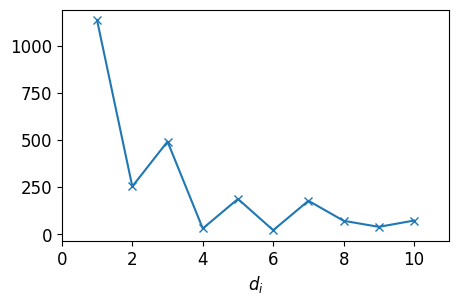

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(range(1, D+1), np.abs(PCYcov), "x-")
axes.set(xlabel=r'$d_i$', xlim=[0, D+1]);

In [42]:
SVy = np.sum([PCYcov[i] * zs[:,i] for i in range(D)], axis=0)

In [43]:
np.allclose(ridge.predict(X_train_dm), SVy.T)

False

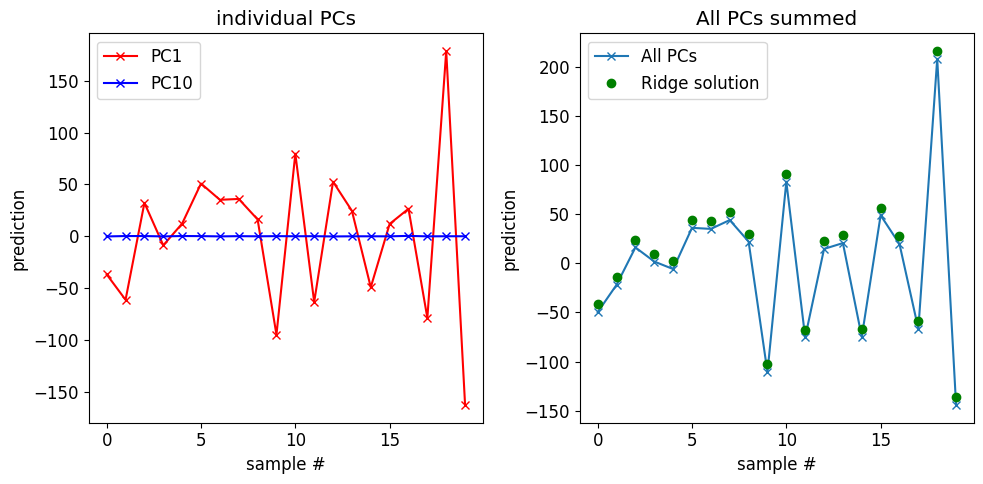

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(PCYcov[0] * zs[:,0], "rx-", label="PC1")
axes[0].plot(PCYcov[9] * zs[:,9], "bx-", label="PC10")
axes[0].set(xlabel="sample #", ylabel="prediction", title="individual PCs")
axes[0].legend()

axes[1].plot(SVy, "x-", label="All PCs")
axes[1].plot(ridge.predict(X_train_dm), "go", label="Ridge solution")
axes[1].set(xlabel="sample #", ylabel="prediction", title="All PCs summed")
axes[1].legend()
plt.tight_layout();

Whew! That was intense! The punchline of that analysis was that we can think of ridge regression much like we think of PCR: taking a weighted combination of PCs to predict $y$, except that here we don't just pick 1 or 2 PCs, but pick them all, and weight them depending on how we choose $\lambda$.

## Part 10 (4 points)

Let's bring this all together now. Write a `for` loop, to loop over all dimensions (or degrees of freedom, in the case of ridge regression) from 1 to $D=10$ and fit all three models (PCR, PLS, ridge) on our training data and then compute $R^2$ on our testing data. (All of the components to do this you have already coded up, above, so just gather them and put them in a for loop. Hint that you will need the rootfinding function from Part 7 to find the correct lambda for each unique degree of freedom).

* Plot the $R^2$ as a function of $d$ or degrees of freedom. Your plot should look like this:

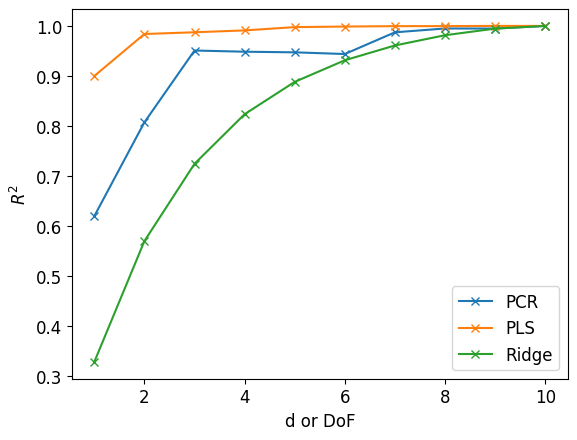

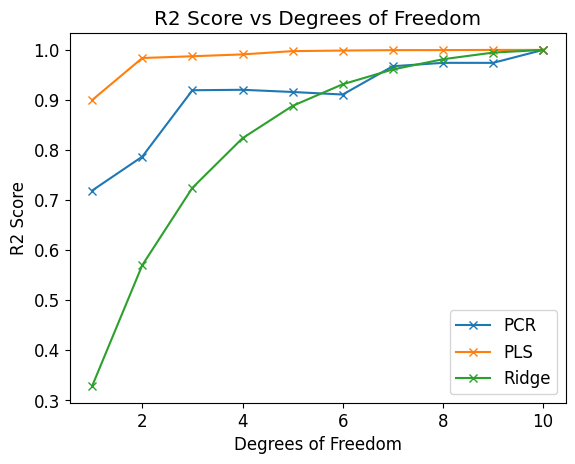

In [52]:
# Initialize arrays to store R2 scores
r2_scores_pcr = []
r2_scores_pls = []
r2_scores_ridge = []
def find_lambda(dof, y_train):
    def func(lambda_):
        return np.sum(S** 2 / (S ** 2 + lambda_)) - dof

    # Use root finding to find the lambda value
    result = root(func, x0=1)
    lambda_ = result.x[0]
    return lambda_
# Loop over dimensions (or degrees of freedom)
for dof in range(1, 11):
    # Fit PCR model
    pca = PCA(n_components=dof)
    X_train_pcr = pca.fit_transform(X_train)
    X_test_pcr = pca.transform(X_test)
    linear_regression = LinearRegression()
    linear_regression.fit(X_train_pcr, y_train)
    r2_pcr = linear_regression.score(X_test_pcr, y_test)
    r2_scores_pcr.append(r2_pcr)

    # Fit PLS model
    pls_model = PLSRegression(n_components=dof)
    pls_model.fit(X_train, y_train)
    r2_pls = pls_model.score(X_test, y_test)
    r2_scores_pls.append(r2_pls)


    # Find lambda for Ridge model
    lambda_ = find_lambda(dof, y_train)

    # Ensure lambda is non-negative
    lambda_ = max(0, lambda_)

    # Fit Ridge model
    ridge = Ridge(alpha=lambda_)
    ridge.fit(X_train, y_train)
    r2_ridge = ridge.score(X_test, y_test)
    r2_scores_ridge.append(r2_ridge)

# Plot R2 scores as a function of degrees of freedom
degrees_of_freedom = np.arange(1, 11)
plt.plot(degrees_of_freedom, r2_scores_pcr,'x-', label='PCR')
plt.plot(degrees_of_freedom, r2_scores_pls,'x-', label='PLS')
plt.plot(degrees_of_freedom, r2_scores_ridge,'x-', label='Ridge')
plt.xlabel('Degrees of Freedom')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Degrees of Freedom')
plt.legend()
plt.show()


PLS does an impressive job! PCR gets close pretty quickly, but still, PLS might be worth the extra effort. Ridge, on the other hand, is slower to catch up, because it does not force the solution to live strictly in a subset of dimensions.

## Part 11 (4 points)

Shifting gears, let's examine a dataset with PCA and factor analysis. Probabilistic PCA and FA are both great models because they are defined with an explicit log likelihood function which allows us to do model selection with cross-validation. (Standard PCA simply seeks projections that maximize variance -- it's not clear (although it is possible) how to formulate standard PCA for cross-validation). For this reason, and many others, moving into a probabilitic language is powerful!

We will use sklearn's implementation of [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) (which actually is PPCA!) to do model comparision. After showing you an example of how to do it with PCA, you will then use sklearn's implementation of [`FactorAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html) to do it again.

* Load a dataset using `np.genfromtxt`. The dataset is a 200 times 10 matrix, with 200 samples from a dataset with 10 features. We will do dimensionality reduction to determine how many important latent features are in the data.

* We need to divide the dataset into a train and test set for cross validation. Sklearn has a handy function [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) for doing this. You provide it a model (e.g. `pca`) and some data, and it automatically partitions the data, fits the model, and returns the score (i.e., $R^2$) on the test data.

* Do `from sklearn.model_selection import cross_val_score` and `from sklearn.decomposition import PCA` to import the necessary funtionality from sklearn.

* Then we will loop over the number of latent dimensions we will use to fit the model and perform cross-validation.

In [53]:
x = np.genfromtxt('https://raw.githubusercontent.com/BU-BME-DataSci-ML/Spring-2023/main/Homework4/10D.csv', delimiter=",")

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [55]:
D = np.shape(x)[1]
pca_scores = np.empty(D)
for d in range(D):
  pca = PCA(n_components=d+1)
  pca_scores[d] = np.mean(cross_val_score(pca, x))

When we plot the cross-validated log likelihood we see a clear peak at $P=3$, meaning that these data are best described as having 3 latent dimensions! (Secret: they were generated that way!)

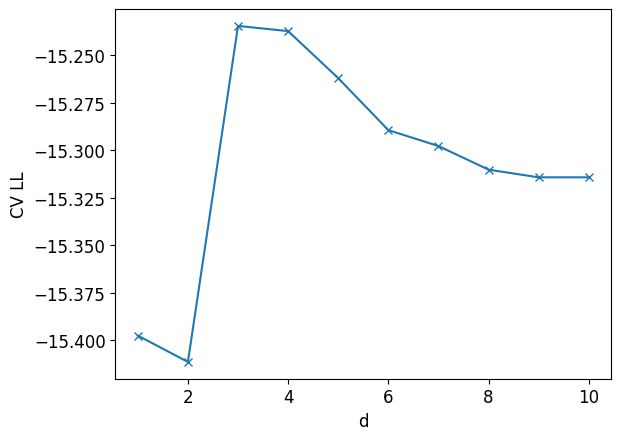

In [56]:
fig, ax = plt.subplots()
plt.plot(range(1,D+1), pca_scores, "x-", label="PCA");
plt.xlabel('d')
plt.ylabel('CV LL');

Perform the exact same analysis on a different dataset (loaded below) that is also 10 dimensional. Do `from sklearn.decomposition import FactorAnalysis` to import the FactorAnalysis functionality from sklearn.

Plot the cross-validated log likelihood, like we did above, for both models. Your plot should look like this:

<font color='red'> What do you notice about how PCA performs on this dataset? Factor analysis seems to recover three latent parameters, but PCA does something quite different. Because of the constrained form PCA has compared to factor analysis, PCA needs to continue to increase the dimensionality of the latent space to account for variance in the data, while FA's flexibility allows it to fit the data better. (Secret: these data were generated to have 3 meaningful latent dimensions, and noise in each feature direction what was unique, i.e. the exact kind of data factor analysis is meant to deal with! </font>  


In [57]:
x = np.genfromtxt('https://raw.githubusercontent.com/BU-BME-DataSci-ML/Spring-2023/main/Homework4/10D-2.csv', delimiter=",")

In [58]:
from sklearn.decomposition import FactorAnalysis

In [59]:
D1 = np.shape(x)[1]
pca_scores = np.empty(D1)
for d in range(d):
  pca = PCA(n_components=d+1)
  pca_scores[d] = np.mean(cross_val_score(pca, x))

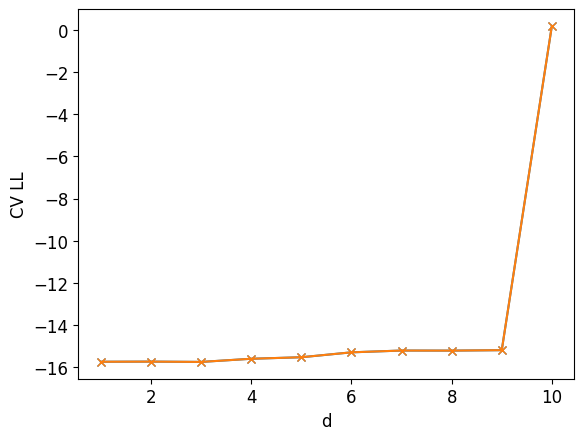

In [62]:
fig, ax = plt.subplots()
plt.plot(range(1,D+1), pca_scores, "x-", label="PCA");
plt.plot(range(1,D1+1), pca_scores, "x-", label="PCA");
plt.xlabel('d')
plt.ylabel('CV LL');